# Deep Recurrent Q-Network

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents pyvirtualdisplay gym[atari,box2d]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import random
import os
import functools
import time
import gin
import PIL
import imageio

from absl import app
from absl import flags
from absl import logging

import gym
from gym.envs.registration import register
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

from IPython import display

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

1 Physical GPUs, 1 Logical GPUs


## Environment Setup

In [2]:
env_name = 'LunarLander-v2'
#env_name = 'CartPole-v1'
random_seed = 42

ROOT_DIR = "."
IMAGES_PATH = os.path.join(ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

# Params for train
max_episodes = 500
max_replay = 10
batch_size = 32
gamma = 0.99
epsilon_min = 0.01
learning_rate = 0.005
target_update_rate = 2
time_steps = 4
#loss_fn = keras.losses.sparse_categorical_crossentropy
#loss_fn = keras.losses.mean_squared_error
loss_fn = keras.losses.MeanSquaredError()
#activation_fn = "softmax"
activation_fn = "linear"

keras.backend.clear_session()
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

## Replay Buffer

In [3]:
class ReplayBuffer:
    def __init__(self, time_steps, batch_size=32, capacity=10000):
        self.time_steps = time_steps
        self.batch_size = batch_size
        self.buffer = deque(maxlen=capacity)
    
    def put(self, state, action, reward, next_state, done):
        self.buffer.append([state, action, reward, next_state, done])
    
    def sample(self):
        minibatch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, done = map(np.asarray, zip(*minibatch))
        states = np.array(states).reshape(self.batch_size, self.time_steps, -1)
        next_states = np.array(next_states).reshape(self.batch_size, self.time_steps, -1)
        return states, actions, rewards, next_states, done
    
    def size(self):
        return len(self.buffer)

## Deep Recurrent Q-Network

In [4]:
class DRQN:
    def __init__(self, network_name, state_dim, action_dim, time_steps=4, loss_fn=keras.losses.MeanSquaredError(), gamma=0.99, learning_rate=0.005, max_episodes=500, eps_min=0.01):
        self.network_name = network_name
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.lr = learning_rate
        self.eps_den = (max_episodes * 0.85)
        self.eps_min = eps_min
        self.time_steps = time_steps
        self.loss_fn = loss_fn
        self.optimizer = Adam(lr=self.lr)
        
        self.checkpoint_folder = os.path.join(ROOT_DIR, "training/" + self.network_name)
        os.makedirs(self.checkpoint_folder, exist_ok=True)
        self.checkpoint_path = os.path.join(self.checkpoint_folder, 'cp-{epoch:04d}.ckpt')
        self.checkpoint_dir = os.path.dirname(self.checkpoint_path)

        self.model = self.create_model()

    def create_model(self):
        model = tf.keras.Sequential([
            Input((self.time_steps, self.state_dim)),
            LSTM(32, activation='tanh'),
            Dense(16, activation='relu'),
            Dense(self.action_dim)
        ])
        return model
    
    def epsilon(self, episode):
        eps = max(1 - episode / self.eps_den, self.eps_min)
        return eps
    
    def epsilon_greedy(self, state, episode):
        if random.uniform(0,1) < self.epsilon(episode):
            action = np.random.randint(self.action_dim)
        else:
            Q_value = self.predict(state)[0]
            action = np.argmax(Q_value)
        return action
    
    def predict(self, state):
        return self.model.predict(state)
    
    def get_action(self, state, episode):
        state = np.reshape(state, [1, self.time_steps, self.state_dim])
        return self.epsilon_greedy(state, episode)
    
    def train(self, states, targets):
        targets = tf.stop_gradient(targets)
        with tf.GradientTape() as tape:
            logits = self.model(states, training=True)
            assert targets.shape == logits.shape
            loss = self.loss_fn(targets, logits)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    
    def load(self, weights=''):
        if weights:
             self.model.load_weights(weights)
        else:
            latest = tf.train.latest_checkpoint(self.checkpoint_dir)
            if latest is not None:
                self.model.load_weights(latest)

    def save(self, e):
        self.model.save_weights(self.checkpoint_path.format(epoch=e))
    
    def clean(self):
        for f in os.listdir(self.checkpoint_folder):
            os.remove(os.path.join(self.checkpoint_folder, f))

## Agent Class

In [17]:
class Agent:
    def __init__(self, env_name, random_seed=42, time_steps=4, loss_fn=keras.losses.MeanSquaredError(), gamma=0.95, learning_rate=0.005, max_episodes=500, eps_min=0.01, batch_size=32, max_replay=10, target_update_rate=50):
        self.env = gym.make(env_name)
        self.env.seed(random_seed)
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_rate = target_update_rate
        self.time_steps = time_steps
        self.states = np.zeros([self.time_steps, self.state_dim])
        
        self.frames = []
        self.rewards = []
        
        self.image_name = env_name + ".gif"
        self.image_path = os.path.join(IMAGES_PATH, self.image_name)
        
        self.main_model = DRQN("main", self.state_dim, self.action_dim, self.time_steps, loss_fn, self.gamma, learning_rate, max_episodes, eps_min)
        self.target_model = DRQN("target", self.state_dim, self.action_dim, self.time_steps, loss_fn, self.gamma, learning_rate, max_episodes, eps_min)
        self.target_update()

        self.buffer = ReplayBuffer(self.time_steps, self.batch_size)
        
    def cp_init(self):
        self.main_model.clean()
        self.target_model.clean()
        
    def convert_time(self, t):
        hours, rem = divmod(t, 3600)
        minutes, seconds = divmod(rem, 60)
        return hours, minutes, seconds
    
    def make_gif(self):
        frame_images = [PIL.Image.fromarray(frame) for frame in self.frames]
        frame_images[0].save(self.image_path, format='GIF', append_images=frame_images[1:], save_all=True, duration=120, loop=0)
    
    def show_gif(self):
        html_img = '<img src=' + self.image_path + ' />'
        display.HTML(html_img)

    def plot_rewards(self):
        plt.figure(figsize=(8, 4))
        plt.plot(self.rewards)
        plt.xlabel("Episode", fontsize=14)
        plt.ylabel("Reward", fontsize=14)
        plt.grid()
        plt.show()
    
    def target_update(self):
        weights = self.main_model.model.get_weights()
        self.target_model.model.set_weights(weights)
    
    def replay(self, max_replay=10):
        for _ in range(max_replay):
            states, actions, rewards, next_states, done = self.buffer.sample()
            next_q_values = self.target_model.predict(next_states).max(axis=1)
            q_values = self.main_model.predict(states)
            q_values[range(self.batch_size), actions] = rewards + (1-done) * next_q_values * self.gamma
            self.main_model.train(states, q_values)
    
    def update_states(self, next_state):
        self.states = np.roll(self.states, -1, axis=0)
        self.states[-1] = next_state
    
    def train(self, max_episodes=1000, max_replay=10):
        train_time, best_reward = 0, -1000
        self.rewards = []
        avg_rewards = []
        self.main_model.load()
        self.main_model.clean()
        for ep in range(max_episodes):
            done, total_reward, time_step = False, 0, 0
            self.states = np.zeros([self.time_steps, self.state_dim])
            self.update_states(self.env.reset())
            while not done:
                action = self.main_model.get_action(self.states, ep)
                next_state, reward, done, _ = self.env.step(action)
                prev_states = self.states
                self.update_states(next_state)
                self.buffer.put(prev_states, action, reward, self.states, done)
                total_reward += reward
                time_step += 1
            self.rewards.append(total_reward)
            avg_reward = np.mean(self.rewards[-100:])
            avg_rewards.append(avg_reward)
            if total_reward >= best_reward:
                best_weights = self.main_model.model.get_weights()
                best_reward = total_reward
                self.main_model.save(ep)
            if self.buffer.size() >= self.batch_size:
                start_time = time.time()
                self.replay(max_replay)
                train_time += time.time() - start_time
                if ep % self.target_update_rate:
                    self.target_update()
            hours, minutes, seconds = self.convert_time(train_time)
            print("\rEpisode: {}, Timestep: {}, Current Reward: {:.5f}, Best Reward: {:.5f}, Avg. Reward: {:.5f}, Train Time: {:0>2}:{:0>2}:{:05.2f}".format(ep, time_step, total_reward, best_reward, avg_reward, int(hours), int(minutes), seconds), end="")
        self.main_model.model.set_weights(best_weights)
        self.main_model.save(ep)

    def play(self):
        self.states = np.zeros([self.time_steps, self.state_dim])
        self.update_states(self.env.reset())
        self.frames = []
        total_reward, step_indx = 0, 0
        while True:
            self.frames.append(self.env.render(mode="rgb_array"))
            action_state = np.reshape(self.states, [1, self.time_steps, self.state_dim])
            Q_value = self.main_model.predict(action_state)[0]
            action = np.argmax(Q_value)
            state, reward, done, _ = self.env.step(action)
            self.update_states(state)
            total_reward += reward
            step_indx += 1
            print("\rTimestep: {}, Reward: {:.5f}".format(step_indx, total_reward), end="")
            if done:
                break
        self.env.close()

## Train

In [18]:
agent = Agent(env_name, random_seed, time_steps, loss_fn, gamma, learning_rate, max_episodes, epsilon_min, batch_size, max_replay, target_update_rate)

In [ ]:
agent.cp_init()
agent.train(max_episodes, max_replay)

In [19]:
agent.train(max_episodes, max_replay)

Episode: 499, Timestep: 1000, Current Reward: -126.64299, Best Reward: 200.12588, Avg. Reward: -101.47563, Train Time: 00:04:57.13

## Display Results

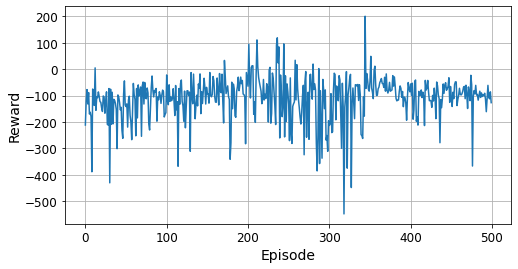

In [20]:
agent.plot_rewards()

## Play

In [21]:
agent.play()

Timestep: 1000, Reward: -12.12333

In [22]:
agent.make_gif()

In [23]:
agent.show_gif()

In [24]:
display.HTML("<img src='images/LunarLander-v2.gif' />")